Baseline model with mean encoding and tfidf

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from nltk.corpus import stopwords
from datetime import datetime
import lightgbm as lgb
from sklearn import *
import gc

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\V
[nltk_data]     Chan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
# read data files
train = pd.read_csv("Dataset/modified/train.csv", parse_dates=["activation_date"])
test = pd.read_csv("Dataset/modified/test.csv", parse_dates=["activation_date"])

Encode catogorical features

In [9]:
cat_cols = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'user_type']
num_cols = ['price', 'image_top_1', 'deal_probability']

for c in cat_cols:
    for c2 in num_cols:
        train_enc = train.groupby(c)[c2].agg(['mean']).reset_index()
        train_enc.columns = ['_'.join([str(c), str(c2), str(c3)]) if c3 != c else c for c3 in train_enc.columns]
        train = pd.merge(train, train_enc, how='left', on=c)
        test = pd.merge(test, train_enc, how='left', on=c)

    if c != 'user_id':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].unique())+list(test[c].unique()))
        train[c] = lbl.transform(train[c].astype(str))
        test[c] = lbl.transform(test[c].astype(str))
    print(c)
del train_enc; gc.collect()

region
city
parent_category_name
category_name
param_1
param_2
param_3
user_type


243

In [16]:
# add feature that indicates if image is available
train['image_available'] = train['image'].map(lambda x: 1 if len(str(x))>0 else 0)
test['image_available'] = test['image'].map(lambda x: 1 if len(str(x))>0 else 0)

In [17]:
train['activation_date'] = pd.to_datetime(train['activation_date']).dt.dayofweek
test['activation_date'] = pd.to_datetime(test['activation_date']).dt.dayofweek

In [20]:
# remove stopwords and extract tfidf features from title and description
sw = stopwords.words('russian')
cat_cols = ['title', 'description']
for c in cat_cols:
    train[c + '_len'] = train[c].map(lambda x: len(str(x))) #Lenth
    train[c + '_wc'] = train[c].map(lambda x: len(str(x).split(' '))) #Word Count

    test[c + '_len'] = test[c].map(lambda x: len(str(x))) #Lenth
    test[c + '_wc'] = test[c].map(lambda x: len(str(x).split(' '))) #Word Count
    if c != 'description':
        feature_cnt = 100
        tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt, stop_words=sw, min_df=3, max_df=0.9)
        train_tfidf = pd.DataFrame(tfidf.fit_transform(train[c].astype(str)).toarray())
        test_tfidf = pd.DataFrame(tfidf.transform(test[c].astype(str)).toarray())
        cols = train_tfidf.columns
        for i in range(feature_cnt):
            train[c + '_tfidf_' + str(i)] = train_tfidf[cols[i]]
            test[c + '_tfidf_' + str(i)] = test_tfidf[cols[i]]
    print(c)

title
description


In [25]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,title_tfidf_92,title_tfidf_93,title_tfidf_94,title_tfidf_95,title_tfidf_96,title_tfidf_97,title_tfidf_98,title_tfidf_99,description_len,description_wc
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,249,112,1217,Кокоби(кокон для сна),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58,7
1,2dac0150717d,39aeb48f0017,17,1314,2,22,122,112,1217,Стойка для Одежды,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,7
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,84,112,1217,Philips bluray,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99,16
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,38,112,1217,Автокресло,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,3
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,278,124,46,"ВАЗ 2110, 2003",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,4


In [26]:
# fill na
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [32]:
train.shape

(1503424, 147)

In [33]:
# features to be excluded
ex_col = ['item_id', 'user_id', 'deal_probability', 'title', 'description', 'image']

col = [c for c in train.columns if c not in ex_col]

Spliting train dataset to training and testing

In [29]:
# split training and testing set
x1, x2, y1, y2 = model_selection.train_test_split(train[col], train['deal_probability'].values,
                                                 test_size=0.20, random_state=19)

Lightgbm model

In [ ]:
import lightgbm as lgb

In [30]:
# parameters for lightgbm
params = {'learning_rate': 0.02,
         'boosting': 'gbdt',
         'objective': 'regression',
         'metric': ['auc', 'rmse'],
         'is_training_metric': True,
         'seed': 19, 'num_leaves': 32,
         'feature_fraction': 0.9, 'bagging_fraction': 0.8,
         'bagging_freq': 5}

In [31]:
# training lightgbm
model = lgb.train(params, lgb.Dataset(x1, label=y1), 3000,
                 lgb.Dataset(x2, label=y2), verbose_eval=200,
                 early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.760374	valid_0's rmse: 0.230389
[400]	valid_0's auc: 0.763305	valid_0's rmse: 0.228671
[600]	valid_0's auc: 0.764538	valid_0's rmse: 0.227903
[800]	valid_0's auc: 0.765103	valid_0's rmse: 0.227478
[1000]	valid_0's auc: 0.765628	valid_0's rmse: 0.227132
[1200]	valid_0's auc: 0.766304	valid_0's rmse: 0.226808
[1400]	valid_0's auc: 0.766674	valid_0's rmse: 0.226567
[1600]	valid_0's auc: 0.766955	valid_0's rmse: 0.226369
[1800]	valid_0's auc: 0.767387	valid_0's rmse: 0.226206
[2000]	valid_0's auc: 0.767743	valid_0's rmse: 0.22603
Early stopping, best iteration is:
[2036]	valid_0's auc: 0.767798	valid_0's rmse: 0.226011


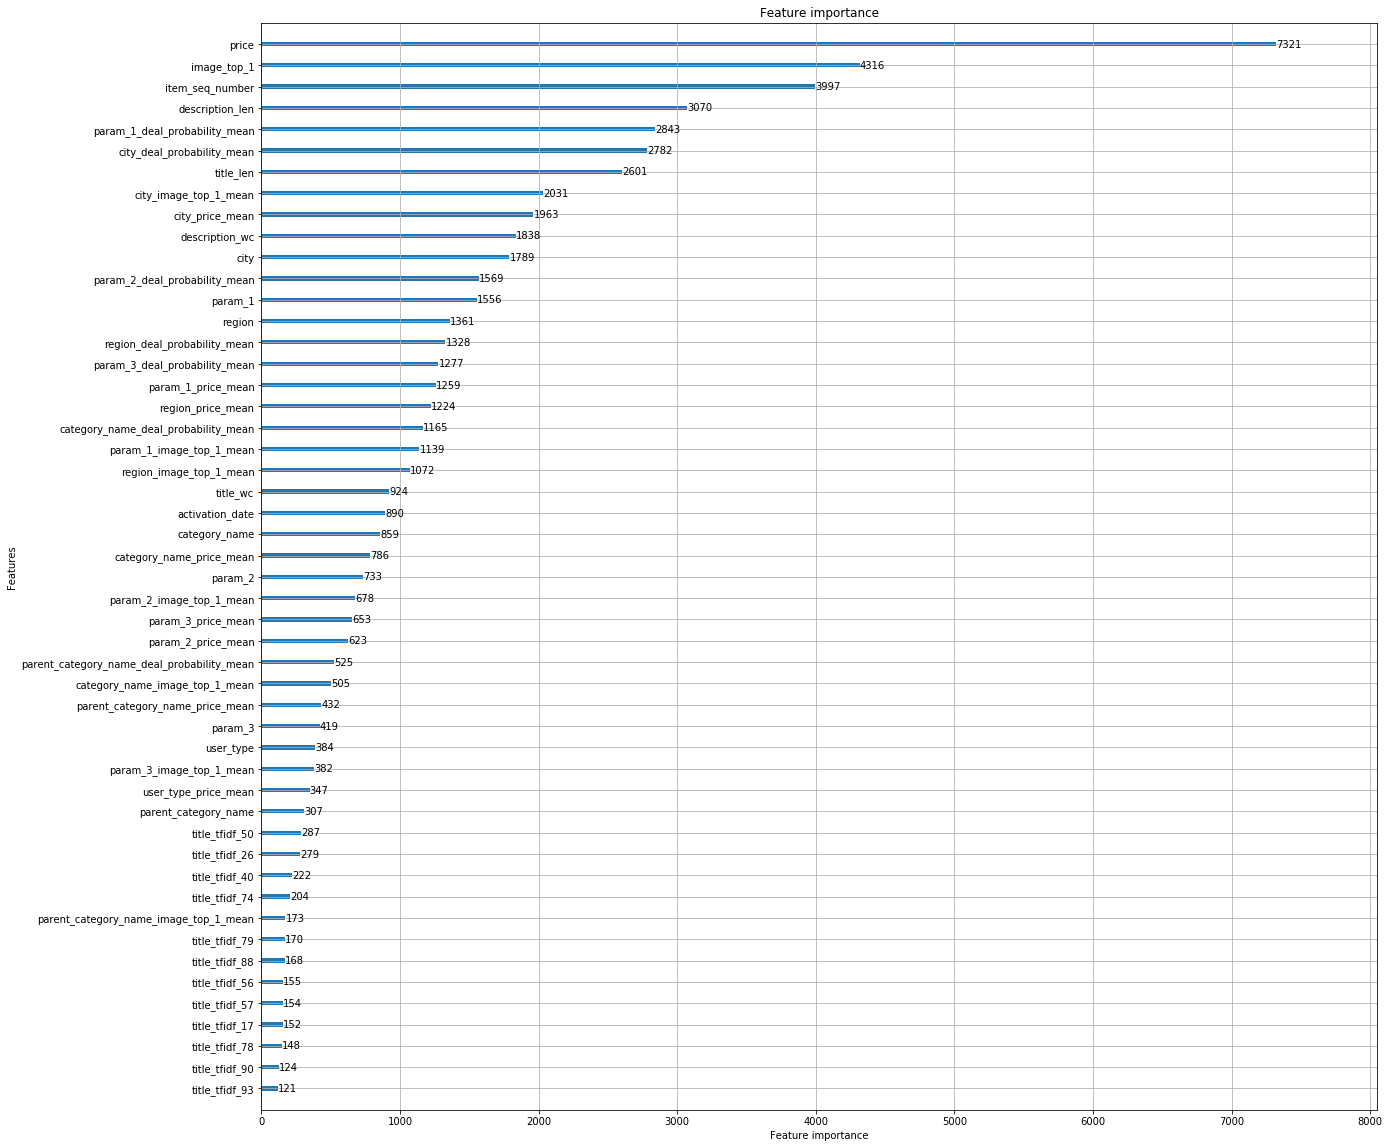

In [60]:
# plot feature importance given by the model
lgb.plot_importance(model, max_num_features=50, figsize=(20, 20))

In [35]:
# predict with trained lightgbm model
test['deal_probability'] = model.predict(test[col], num_iteration=model.best_iteration)

In [36]:
test['deal_probability'] = test['deal_probability'].clip(0., 1.)

In [38]:
test[['item_id', 'deal_probability']].to_csv('submission_lgb.csv', index=False)